# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [121]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/erik/Code/Skola/ID2223/mlfs-book
HopsworksSettings initialized!


In [122]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [123]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 15, 44, 47, 832238)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [124]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON_A").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 15:44:47,867 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 15:44:47,875 INFO: Initializing external client
2025-11-18 15:44:47,876 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 15:44:48,547 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 15:44:49,330 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279161


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 
Found 4 unique sensor URLs: ['https://api.waqi.info/feed/A191545', 'https://api.waqi.info/feed/A474136', 'https://api.waqi.info/feed/A469291', 'https://api.waqi.info/feed/A66394']

--- Processing sensor: https://api.waqi.info/feed/A191545 ---
------------------------------
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 
✅ Street: Steyrerweg, Model Code: a191545
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 
ℹ️ Yesterday's PM25: 1.350000023841858, Lag 1 PM25: 1.7999999523162842
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
ℹ️ Retrieved 6 rows of weather forecast data.
ℹ️ Forecast start lag features set: L1=1.35
Retrieving model: air_quality_xgboost_model_a191545
2025-11-18 15:45:04,464 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/490182 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125942 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25963 elapsed<00:00 remaining<?

✅ Prediction completed. First predicted PM25: 4.70NE


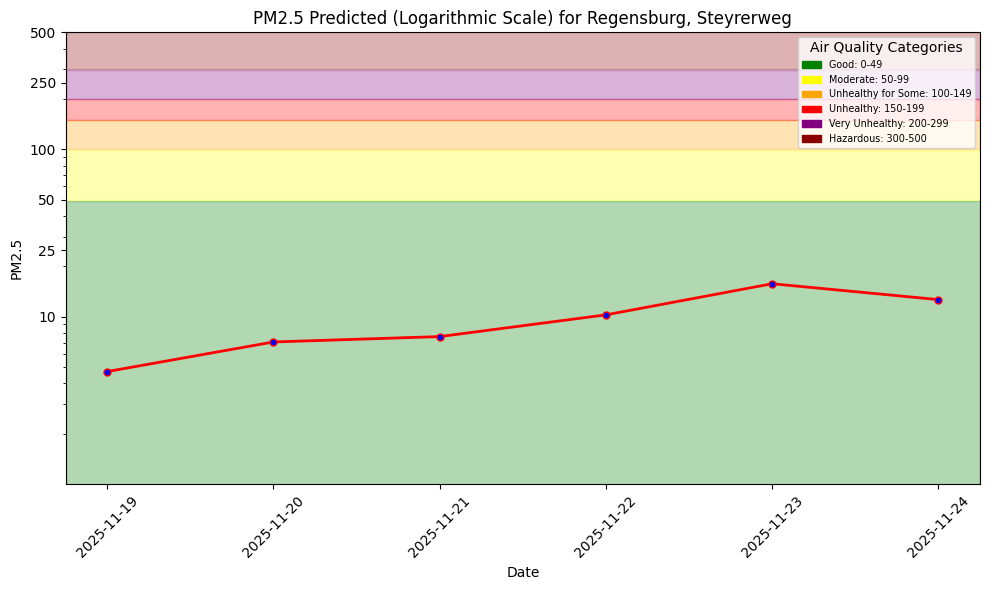

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a191545_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a191545_1_offline_fg_materialization/executions
2025-11-18 15:45:28,613 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 15:45:31,849 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:46:58,343 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 15:46:58,498 INFO: Waiting for log aggregation to finish.
2025-11-18 15:47:07,177 INFO: Execution finished successfully.
✅ Predictions inserted into FG: aq_predictions_a191545 (Version 1).
ℹ️ Starting hindcast data retrieval...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 
⚠️

Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a191545_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a191545_1_offline_fg_materialization/executions
2025-11-18 15:47:30,931 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 15:47:34,145 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 15:47:37,416 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:49:03,825 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 15:49:03,997 INFO: Waiting for log aggregation to finish.
2025-11-18 15:49:12,609 INFO: Execution finished successfully.


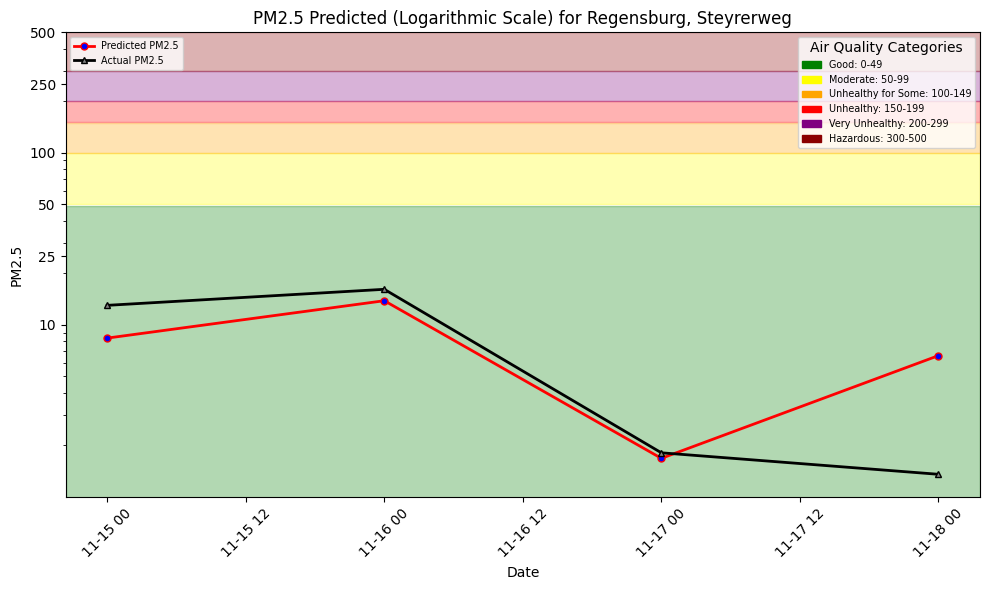

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_forecast_a191545.png: 0.000…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_a191545.png: …

✅ See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279161/settings/fb/path/Resources/airquality

--- Processing sensor: https://api.waqi.info/feed/A474136 ---
------------------------------
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 
✅ Street: Pfeilstraße, Model Code: a474136
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
ℹ️ Yesterday's PM25: 1.7999999523162842, Lag 1 PM25: 1.7999999523162842
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 
ℹ️ Retrieved 6 rows of weather forecast data.
ℹ️ Forecast start lag features set: L1=1.80
Retrieving model: air_quality_xgboost_model_a474136
2025-11-18 15:49:26,311 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/369497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/126618 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26486 elapsed<00:00 remaining<?

✅ Prediction completed. First predicted PM25: 6.20NE


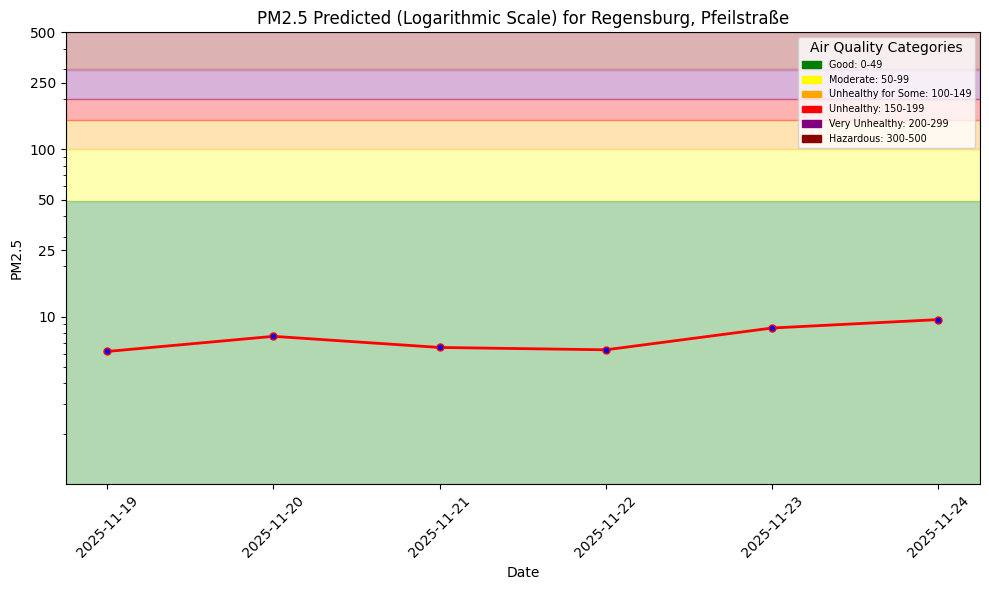

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fg/1718995


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a474136_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a474136_1_offline_fg_materialization/executions
2025-11-18 15:50:16,686 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 15:50:23,161 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:51:52,977 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 15:51:53,136 INFO: Waiting for log aggregation to finish.
2025-11-18 15:52:01,710 INFO: Execution finished successfully.
✅ Predictions inserted into FG: aq_predictions_a474136 (Version 1).
ℹ️ Starting hindcast data retrieval...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.55s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
⚠️ Hi

Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a474136_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a474136_1_offline_fg_materialization/executions
2025-11-18 15:52:25,542 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 15:52:28,797 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:53:49,017 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 15:53:49,178 INFO: Waiting for log aggregation to finish.
2025-11-18 15:53:57,754 INFO: Execution finished successfully.


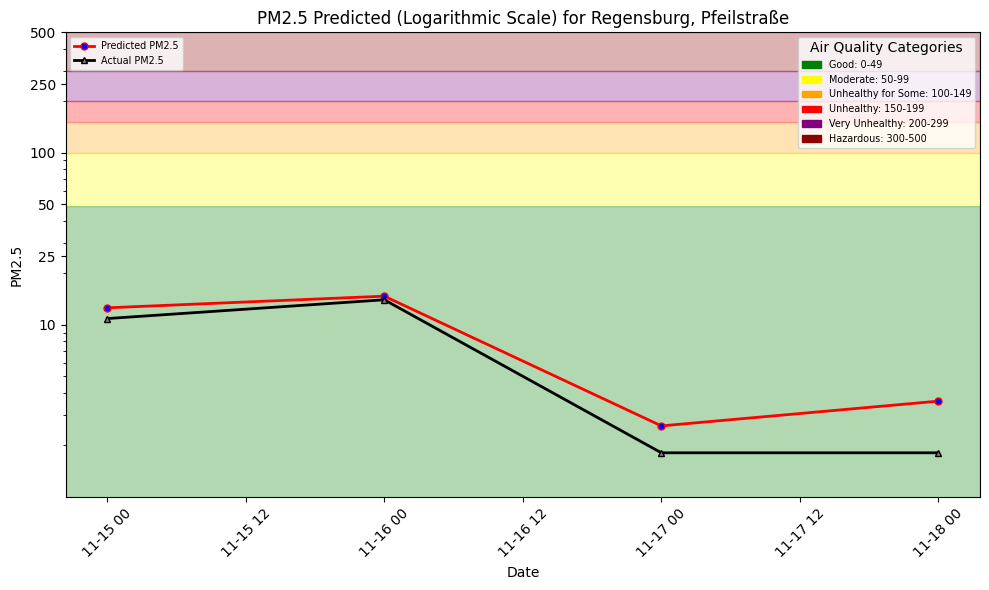

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_forecast_a474136.png: 0.000…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_a474136.png: …

✅ See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279161/settings/fb/path/Resources/airquality

--- Processing sensor: https://api.waqi.info/feed/A469291 ---
------------------------------
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 
✅ Street: Hafnersteig, Model Code: a469291
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 
ℹ️ Yesterday's PM25: 0.25, Lag 1 PM25: 1.8300000429153442
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.57s) 
ℹ️ Retrieved 6 rows of weather forecast data.
ℹ️ Forecast start lag features set: L1=0.25
Retrieving model: air_quality_xgboost_model_a469291
2025-11-18 15:54:12,250 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/375867 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/100682 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26495 elapsed<00:00 remaining<?

✅ Prediction completed. First predicted PM25: 0.84NE


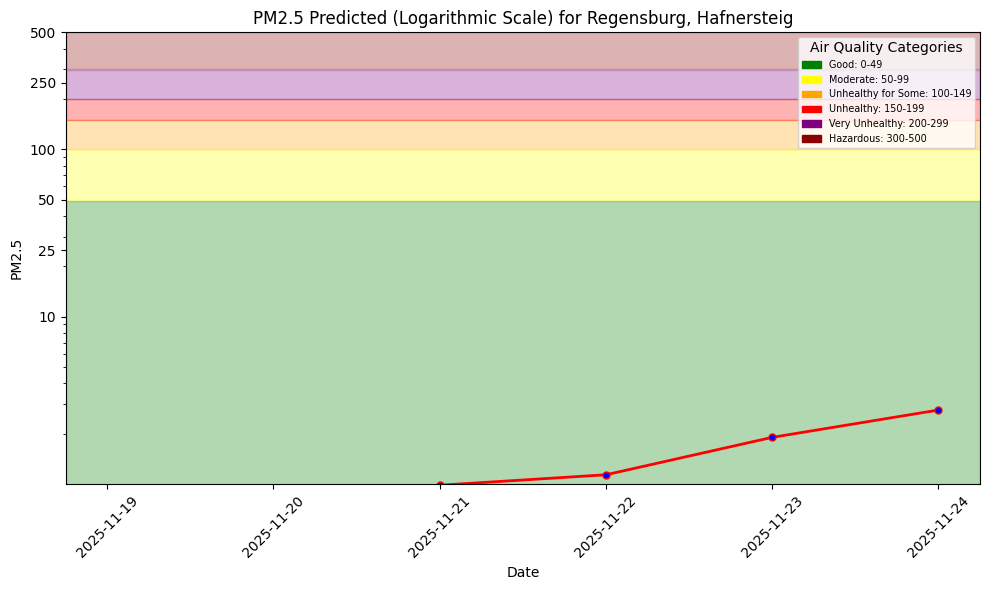

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fg/1721991


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a469291_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a469291_1_offline_fg_materialization/executions
2025-11-18 15:54:35,715 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 15:54:38,973 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:56:20,846 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 15:56:27,285 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-18 15:56:27,715 INFO: Waiting for log aggregation to finish.
2025-11-18 15:56:27,716 INFO: Execution finished successfully.
✅ Predictions inserted into FG: aq_predictions_a469291 (Version 1).
ℹ️ Starting hindcast data retrieval...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Se

Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a469291_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a469291_1_offline_fg_materialization/executions
2025-11-18 15:57:13,005 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 15:57:16,190 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:59:02,034 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 15:59:02,220 INFO: Waiting for log aggregation to finish.
2025-11-18 15:59:10,800 INFO: Execution finished successfully.


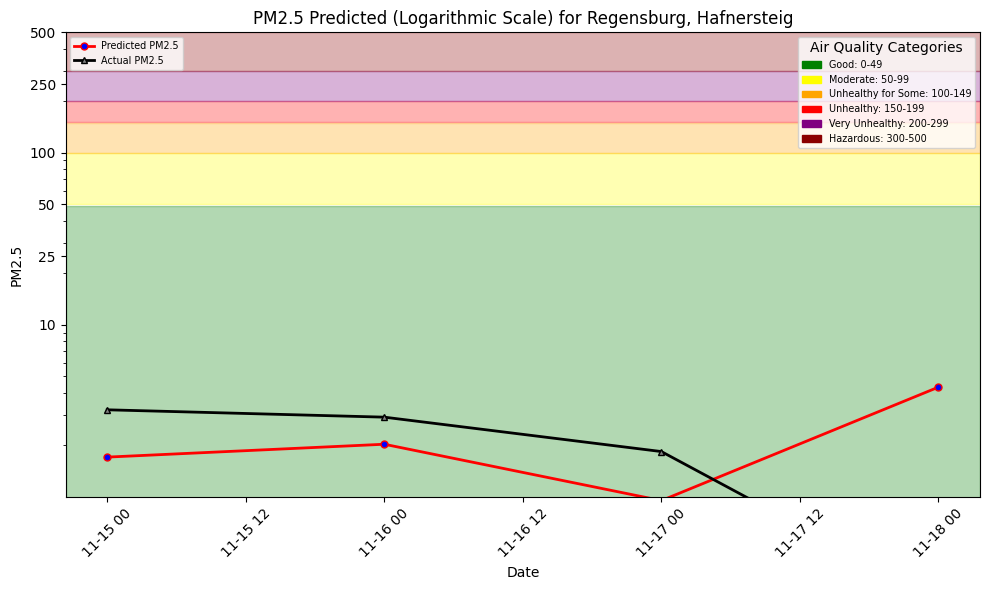

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_forecast_a469291.png: 0.000…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_a469291.png: …

✅ See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279161/settings/fb/path/Resources/airquality

--- Processing sensor: https://api.waqi.info/feed/A66394 ---
------------------------------
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
✅ Street: Fichtelgebirgstraße, Model Code: a66394
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 
ℹ️ Yesterday's PM25: 0.4699999988079071, Lag 1 PM25: 0.41999998688697815
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 
ℹ️ Retrieved 6 rows of weather forecast data.
ℹ️ Forecast start lag features set: L1=0.47
Retrieving model: air_quality_xgboost_model_a66394
2025-11-18 15:59:25,635 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/529665 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115392 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26128 elapsed<00:00 remaining<?

✅ Prediction completed. First predicted PM25: 1.61NE


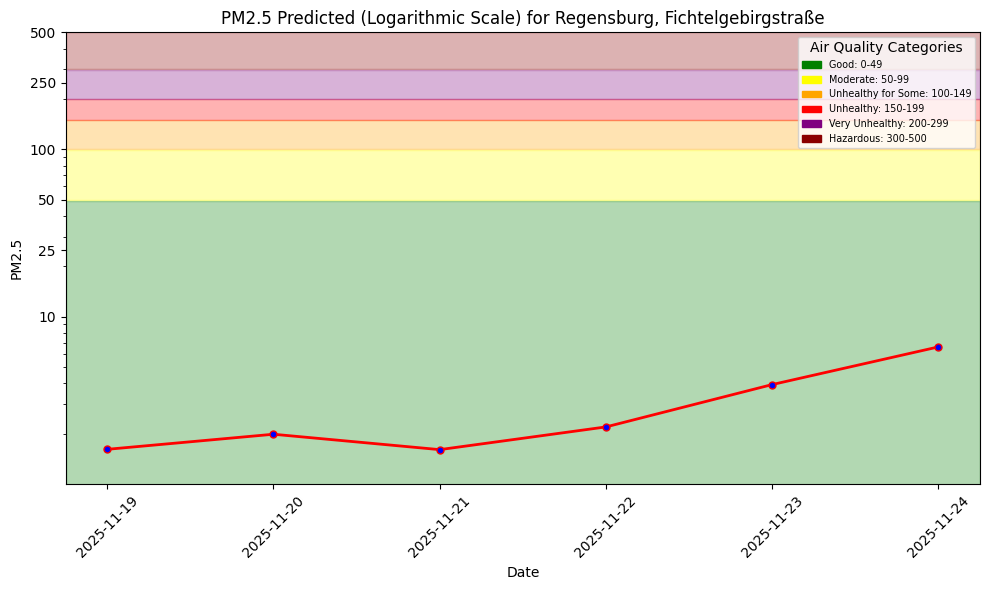

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279161/fs/1273929/fg/1721993


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a66394_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a66394_1_offline_fg_materialization/executions
2025-11-18 16:00:14,741 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 16:00:21,107 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 16:02:29,013 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 16:02:29,182 INFO: Waiting for log aggregation to finish.
2025-11-18 16:02:37,686 INFO: Execution finished successfully.
✅ Predictions inserted into FG: aq_predictions_a66394 (Version 1).
ℹ️ Starting hindcast data retrieval...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
⚠️ Hindc

Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_a66394_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279161/jobs/named/aq_predictions_a66394_1_offline_fg_materialization/executions
2025-11-18 16:03:15,319 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 16:03:18,505 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 16:04:41,549 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 16:04:41,705 INFO: Waiting for log aggregation to finish.
2025-11-18 16:04:50,339 INFO: Execution finished successfully.


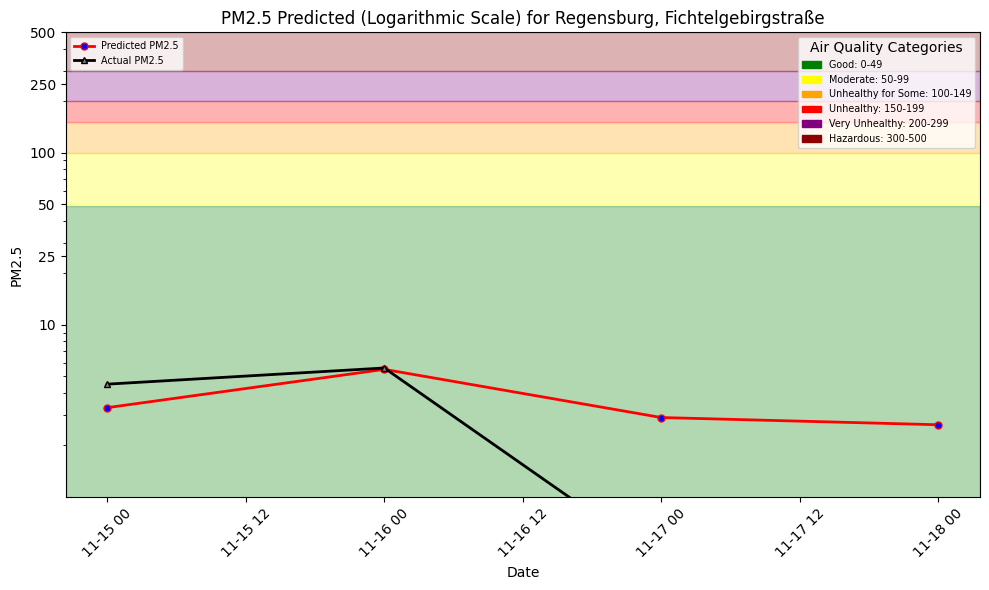

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_forecast_a66394.png: 0.000%…

Uploading /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_a66394.png: 0…

✅ See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279161/settings/fb/path/Resources/airquality

--- All sensors processed. ---


In [ ]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
# Assuming 'project', 'fs', 'root_dir', 'today', 'city', 'country' are defined/initialized

# --- 1. Connect and Load Feature Groups ---

weather_fg = fs.get_feature_group(
    name='weather_a',
    version=1,
)
airquality_fg = fs.get_feature_group(
    name='air_quality_a',
    version=1,
)

# --- 2. Get Unique Sensor URLs and Start Loop ---

# Read all unique URLs from the air_quality feature group
all_urls_df = airquality_fg.select('url').read()
urls = all_urls_df['url'].unique().tolist()
print(f"Found {len(urls)} unique sensor URLs: {urls}")

for url in urls:
    print(f"\n--- Processing sensor: {url} ---")
    print("-" * 30)

    # Dynamic sensor identification
    code = url.split("/")[-1].lower()
    
    street_df = airquality_fg.select('street').filter(airquality_fg.url == url).read()
    if street_df.empty:
        print(f"Skipping {url}: No street data found.")
        continue
        
    street = street_df.iloc[0]['street']
    print(f"✅ Street: {street}, Model Code: {code}")

  

    # Filter out data for the current sensor/url
    yesterday_data = airquality_fg.filter(airquality_fg.url == url).read()
    # Order by date descending to get the most recent row (yesterday)
    yesterday_data = yesterday_data.sort_values(by='date', ascending=False)
    
    # Skip if we don't have historical data for lag features
    if yesterday_data.empty:
        print(f"Skipping {url}: No historical data for lag features found.")
        continue
        
    # Check if the needed lag features exist before printing
    pm25_val = yesterday_data.iloc[0]['pm25'] if 'pm25' in yesterday_data.columns else 'N/A'
    lag1_val = yesterday_data.iloc[0]['lag_1_pm25'] if 'lag_1_pm25' in yesterday_data.columns else 'N/A'
    print(f"Yesterday's PM25: {pm25_val}, Lag 1 PM25: {lag1_val}")

  

    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    
    # Ensure weather data is available
    if batch_data.empty:
        print(f"⚠️ Skipping {url}: No weather forecast data available.")
        continue

    # Order by date
    batch_data = batch_data.sort_values(by='date')
    print(f"ℹ️ Retrieved {len(batch_data)} rows of weather forecast data.")
    
    # Initialize lag features for the first row of the forecast using yesterday's actual data
    first_forecast_index = batch_data.index[0]
    first_yesterday_index = yesterday_data.index[0]
    
    batch_data.loc[first_forecast_index, 'lag_1_pm25'] = yesterday_data.loc[first_yesterday_index, 'pm25']
    batch_data.loc[first_forecast_index, 'lag_2_pm25'] = yesterday_data.loc[first_yesterday_index, 'lag_1_pm25']
    batch_data.loc[first_forecast_index, 'lag_3_pm25'] = yesterday_data.loc[first_yesterday_index, 'lag_2_pm25']
    
    print(f"ℹ️ Forecast start lag features set: L1={batch_data.loc[first_forecast_index, 'lag_1_pm25']:.2f}")

    
    mr = project.get_model_registry()

    # Dynamic Model Name: uses the 'code'
    model_name = f"air_quality_xgboost_model_{code}"
    print(f"Retrieving model: {model_name}")
    retrieved_model = mr.get_model(
        name=model_name,
        version=1
    )

    fv = retrieved_model.get_feature_view()
    saved_model_dir = retrieved_model.download()

    # Load the XGBoost regressor model
    retrieved_xgboost_model = XGBRegressor()
    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")
    
    # --- 6. Make Predictions and Feature Chaining ---

    # Initialize the prediction column
    batch_data['predicted_pm25'] = 0.0

    # Predict the first row using yesterday's data (already set in step 4)
    features = ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    
    batch_data.loc[first_forecast_index, 'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[features].iloc[0].values.reshape(1, -1)
    )[0]
    
    # Feature Chaining: Predict subsequent rows using the previous predicted value
    for i in range(1, len(batch_data)):
        current_index = batch_data.index[i]
        previous_index = batch_data.index[i-1]
        
    
        batch_data.loc[current_index, 'lag_1_pm25'] = batch_data.loc[previous_index, 'predicted_pm25']
        batch_data.loc[current_index, 'lag_2_pm25'] = batch_data.loc[previous_index, 'lag_1_pm25']
        batch_data.loc[current_index, 'lag_3_pm25'] = batch_data.loc[previous_index, 'lag_2_pm25']
        
        # Make prediction for the current row
        batch_data.loc[current_index, 'predicted_pm25'] = retrieved_xgboost_model.predict(
            batch_data[features].loc[current_index].values.reshape(1, -1)
        )[0]
    
    print(f"Prediction completed. First predicted PM25: {batch_data.iloc[0]['predicted_pm25']:.2f}")

  
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])

   
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{code}.png" # Dynamic file name
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    plt.show()

    # Dynamic Monitoring Feature Group Name
    monitor_fg_name = f'aq_predictions_{code}'
    monitor_fg = fs.get_or_create_feature_group(
        name=monitor_fg_name,
        description=f'Air Quality prediction monitoring for {street}',
        version=1,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )

    monitor_fg.insert(batch_data, wait=True)
    print(f"Predictions inserted into FG: {monitor_fg_name} (Version 1).")

  
    
    print("Starting hindcast data retrieval...")
    
    # 1. Retrieve all necessary columns from the Feature Group
    monitoring_df = monitor_fg.select(['date', 'predicted_pm25', 'street', 'days_before_forecast_day']).read()

    monitoring_df = monitoring_df[
        (monitoring_df['days_before_forecast_day'] == 1) & 
        (monitoring_df['street'] == street)
    ].copy()
    
    # 3. Prepare prediction data
    preds_df = monitoring_df[['date', 'predicted_pm25']]
    
    # Get actual outcome data (sensor-specific)
    outcome_df = airquality_fg.select(['date', 'pm25']).filter(airquality_fg.url == url).read()
    
    # Merge prediction with outcome
    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # Backfill predictions if necessary
    if len(hindcast_df) == 0:
        print("Hindcast empty. Attempting backfill...")
        
       
        history_df = airquality_fg.filter(airquality_fg.url == url).read()
        
        hindcast_df = util.backfill_predictions_for_monitoring(
            weather_fg,    
            history_df,      
            monitor_fg,   
            retrieved_xgboost_model
        )

    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{code}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()



    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    
    # Create dynamic paths using street name and code
    dataset_path = f"Resources/airquality/{city}_{street}_{code}_{str_today}"

    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")

    dataset_api.upload(pred_file_path, f"{dataset_path}_forecast.png", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"{dataset_path}_hindcast.png", overwrite=True)

    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")
    
# Loop ends
print("\n--- All sensors processed. ---")

---

In [129]:
import os

template = """
# Air Quality Dashboard

![Hopsworks Logo](../titanic/assets/img/logo.png)

{% include air-quality.html %}

### 7-Day Forecasts

*FORECAST*

There is also a Python program to interact with the air quality ML system using language (text, voice),
powered by a [function-calling LLM](https://www.hopsworks.ai/dictionary/function-calling-with-llms).

---

# Model Performance Monitoring

1-Day Hindcast: Predictions vs Outcomes

*HINDCAST*"""

# --- 1. Collect all necessary metadata (Code, Street) in a single run ---
# Assumes 'urls', 'airquality_fg', and 'root_dir' are available from the preceding cell.
dashboard_metadata = []

print("Collecting metadata for dashboard update...")
for url in urls:
    # Extract code
    code = url.split("/")[-1].lower()
    
    # Fetch metadata (lightweight query)
    meta_df = airquality_fg.select(['street', 'city']).filter(airquality_fg.url == url).read()
    
    # We only include the sensor if we successfully retrieve its metadata
    if not meta_df.empty:
        dashboard_metadata.append({
            "code": code,
            "street": meta_df.iloc[0]['street']
        })

# --- 2. Build the Markdown strings ---
forecast_md = ""
hindcast_md = ""

for item in dashboard_metadata:
    # 📝 Generate Markdown links for Forecast (with a title for clarity)
    forecast_md += f"### {item['street']} Forecast\n"
    forecast_md += f"![Forecast for {item['street']}](./assets/img/pm25_forecast_{item['code']}.png)\n\n"
    
    # 📝 Generate Markdown links for Hindcast (with a title for clarity)
    hindcast_md += f"### {item['street']} Hindcast\n"
    hindcast_md += f"![Hindcast for {item['street']}](./assets/img/pm25_hindcast_1day_{item['code']}.png)\n\n"
    
# --- 3. Read, Replace, and Write the index.md file ---
index_path = f"{root_dir}/docs/air-quality/index.md"

# Define the unique markers placed in the index.md file
FORECAST_MARKER = "*FORECAST*"
HINDCAST_MARKER = "*HINDCAST*"

try:
    # use template
    content = template

    # Replace the forecast marker with the dynamic MD
    content = content.replace(FORECAST_MARKER, forecast_md)

    # Replace the hindcast marker with the dynamic MD
    content = content.replace(HINDCAST_MARKER, hindcast_md)

    # Write the updated content back
    with open(index_path, 'w') as f:
        f.write(content)
        
    print(f"✅ Successfully updated {index_path} with {len(dashboard_metadata)} sensor charts.")

except FileNotFoundError:
    print(f"Error: {index_path} not found. Cannot update dashboard.")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.53s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 
✅ Successfully updated /Users/erik/Code/Skola/ID2223/mlfs-book/docs/air-quality/index.md with 4 sensor charts.
